# Final Assignment by Julian Eppelsheimer - <br> Applied Data Science Capstone Project

## A full version of the business problem can be found under: <br> https://github.com/Julian-E/IBM_Data_Science_Final_Project/blob/main/IBM_Data_Science_Business_Problem.pdf

## Short introduction: <br>
### This project deals with the search of a location for building a new Gym.
### Therefor it will use the Foursquare API to characterize the Long Island City neighborhood (New York), the Allapattah neighborhood (Miami) and the St. James Town neighborhood (Toronto). <br> 
### Afterwards a decision will be made by taking several features into account.

In [1]:
import pandas as pd
import folium
import numpy as np
from bs4 import BeautifulSoup
import requests
import geocoder # import geocoder
from geopy.geocoders import Nominatim
from IPython.display import Image
import matplotlib.pyplot as plt
import json # library to handle JSON files
from pandas.io.json import json_normalize
from sklearn.cluster import KMeans 
from matplotlib import cm
import matplotlib.colors as libc

pd.set_option("max_rows", 150)

## Getting all the needed postal codes from the internet pages: <br>
### 1) St. James Town in Toronto

In [2]:
#Dataframe to store all postal codes
df_postalcodes = pd.DataFrame()
#df_postalcodes = pd.DataFrame(data={"Postal Code":[""], "City":[""], "Neighbourhood":[""]})
df_postalcodes

Empty DataFrame
Columns: []
Index: []

In [3]:
read_url = pd.read_html("https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M")
print(type(read_url))
print(len(read_url))

<class 'list'>
3


In [4]:
df_toronto = read_url[0]
df_toronto = df_toronto[df_toronto["Borough"]!="Not assigned"]
df_toronto.head(10)

Postal Code           Borough                                Neighbourhood
2          M3A        North York                                    Parkwoods
3          M4A        North York                             Victoria Village
4          M5A  Downtown Toronto                    Regent Park, Harbourfront
5          M6A        North York             Lawrence Manor, Lawrence Heights
6          M7A  Downtown Toronto  Queen's Park, Ontario Provincial Government
8          M9A         Etobicoke      Islington Avenue, Humber Valley Village
9          M1B       Scarborough                               Malvern, Rouge
11         M3B        North York                                    Don Mills
12         M4B         East York              Parkview Hill, Woodbine Gardens
13         M5B  Downtown Toronto                     Garden District, Ryerson

In [5]:
df_toronto[df_toronto["Neighbourhood"] == "St. James Town"]

Postal Code           Borough   Neighbourhood
22         M5C  Downtown Toronto  St. James Town

In [6]:
#creating a Dataframe with the needed Postal Codes for the desired neighbourhoods
postal_code_SJT = df_toronto["Postal Code"][df_toronto[df_toronto["Neighbourhood"] == "St. James Town"].index[0]]
df_postalcodes = df_postalcodes.append({"Postal Code":postal_code_SJT, "City":"Toronto", "Neighbourhood":"St. James Town"}, ignore_index=True, sort=False)
df_postalcodes

City   Neighbourhood Postal Code
0  Toronto  St. James Town         M5C

### 2) Allappatah in Miami

In [7]:
url = "https://www.zipdatamaps.com/nh-miami-neighborhood-allapattah"
html_data = requests.get(url).text

In [8]:
#using BeautifulSoup to scrap the web page
soup = BeautifulSoup(html_data, "html5lib")

In [9]:
tables = soup.find_all("table")
print("Amount of tables found in website:", len(tables))


Amount of tables found in website: 2


In [10]:
#we just need the first table
print(tables[0])
index_tables = 0

<table class="table table-striped table-bordered table-hover table-condensed"><tbody><tr><td>Neighborhood Name</td><td>Allapattah <a class="mapzoom" href="javascript:poiZoom(25.79960251,-80.22179413,map,12);" id="[25.79960251,-80.22179413,12]" title="Zoom to Allapattah on map"><i class="fa fa-search-plus"></i></a></td></tr><tr><td>City</td><td><a href="zipcodes-miami-fl">Miami</a></td></tr><tr><td>County</td><td><a href="miami-dade-fl-county-zipcodes">Miami-Dade</a></td></tr><tr><td>Zip Code</td><td><a href="33142">33142</a></td></tr><tr><td>Area Code</td><td><a href="area-code-305">305</a> / <a href="area-code-786">786</a> </td></tr><tr><td>Time Zone</td><td><a href="//www.timezoneatlas.com/united-states-eastern-standard-time-zone-map.php">Eastern Standard Time</a></td></tr><tr><td>Current Time:</td><td><div id="clock"></div>EST</td></tr><tr><td>Population</td><td>4904</td></tr><tr><td>Majority Race</td><td>White 73.9%</td></tr><tr><td>Unemployment Level</td><td> 5.9%</td></tr></tbody

In [11]:
tables_body = soup.find_all("tbody")

cols = len(tables_body[index_tables].find_all("tr")[0])
print(f"Table will have {cols} columns!\n")

df_miami = pd.DataFrame(columns=["Key","Value"])
for r,row in enumerate(tables_body[index_tables].find_all("tr")):
    col = row.find_all("td")
    df_miami = df_miami.append({"Key":col[0].get_text(), "Value":col[1].get_text()}, ignore_index=True)

df_miami.index = df_miami.loc[:,"Key"]
df_miami.drop("Key", axis=1, inplace=True)

df_miami

Table will have 2 columns!



Value
Key                                      
Neighborhood Name             Allapattah 
City                                Miami
County                         Miami-Dade
Zip Code                            33142
Area Code                      305 / 786 
Time Zone           Eastern Standard Time
Current Time:                         EST
Population                           4904
Majority Race                 White 73.9%
Unemployment Level                   5.9%

In [12]:
postal_code_Allah = df_miami.loc["Zip Code","Value"]
df_postalcodes = df_postalcodes.append({"Postal Code":postal_code_Allah, "City":"Miami", "Neighbourhood":"Allappatah"}, ignore_index=True, sort=False)

#tables_body[index_tables]


In [13]:
df_postalcodes


City   Neighbourhood Postal Code
0  Toronto  St. James Town         M5C
1    Miami      Allappatah       33142

### 3) Long Island City in New York City

In [14]:
url = "https://www.zip-codes.com/county/ny-queens.asp"
html_data = requests.get(url).text

In [15]:
soup = BeautifulSoup(html_data, "html5lib")

In [16]:
tables = soup.find_all("tbody")
print("Amount of tables found in website:", len(tables))

Amount of tables found in website: 5


In [17]:
#we need the second table, so tables[1]
print(tables[1])
index_tables = 1

<tbody><tr><td class="label"><strong>ZIP Code</strong></td><td class="info"><strong>Classification</strong></td><td class="info"><strong>City</strong></td><td class="info"><strong>Population</strong></td><td class="info"><strong>Timezone</strong></td><td class="info"><strong>Area Code(s)</strong></td></tr><tr><td class="label"><a href="/zip-code/11004/zip-code-11004.asp" style="text-decoration:underline;" title="ZIP Code 11004, GLEN OAKS, NY">ZIP Code 11004</a></td><td class="info">General</td><td class="info"><a href="/city/ny-glen-oaks.asp" title="Glen Oaks, NY">Glen Oaks</a></td><td class="info">14,016</td><td class="info">Eastern</td><td class="info">516/718</td></tr><tr><td class="label"><a href="/zip-code/11005/zip-code-11005.asp" style="text-decoration:underline;" title="ZIP Code 11005, FLORAL PARK, NY">ZIP Code 11005</a></td><td class="info">General</td><td class="info"><a href="/city/ny-floral-park.asp" title="Floral Park, NY">Floral Park</a></td><td class="info">1,806</td><td

In [18]:
#we need the second table, so tables[1]
df_new_york = pd.DataFrame(columns=["Postal Code", "Neighbourhood", "Population"])

for e,row in enumerate(tables[index_tables].find_all("tr")):
    if e != 0:
        column = row.find_all("td")
        postal_code_NY = column[0].get_text().replace("ZIP Code ", "")
        neighbourhood_NY = column[2].get_text()
        population = float(column[3].get_text().replace(",", "."))
        df_new_york = df_new_york.append({"Postal Code":postal_code_NY, "Neighbourhood":neighbourhood_NY, "Population":population}, ignore_index=True)

df_new_york.head(8)


Postal Code     Neighbourhood  Population
0       11004         Glen Oaks      14.016
1       11005       Floral Park       1.806
2       11101  Long Island City      25.484
3       11102           Astoria      34.133
4       11103           Astoria      38.780
5       11104         Sunnyside      27.232
6       11105           Astoria      36.688
7       11106           Astoria      38.875

In [19]:
df_new_york2 = df_new_york[df_new_york.Neighbourhood == "Long Island City"]
df_new_york2 = df_new_york2[df_new_york2.Population==df_new_york2.Population.max()]
postal_code_LIC = df_new_york2.iloc[0,0]
df_postalcodes = df_postalcodes.append({"Postal Code":postal_code_LIC, "City":"New York", "Neighbourhood":"Long Island City"}, ignore_index=True, sort=False)


### Now we have gathered all the desired Postal Codes:

In [20]:
df_postalcodes

City     Neighbourhood Postal Code
0   Toronto    St. James Town         M5C
1     Miami        Allappatah       33142
2  New York  Long Island City       11101

## Get Coordinates from Postal Codes:

### Geocoder.google API didn't give me any coordinates. So i manually searched them using the developer section of google, by entering the gathered information: <br>
https://developers.google.com/maps/documentation/geocoding/overview


In [21]:
coordinates_demand = []
for i in range(0, len(df_postalcodes), 1):
    tuple_demand = (df_postalcodes.iloc[i,0], df_postalcodes.iloc[i,1], df_postalcodes.iloc[i,2])
    coordinates_demand.append(tuple_demand)
coordinates_demand

[('Toronto', 'St. James Town', 'M5C'),
 ('Miami', 'Allappatah', '33142'),
 ('New York', 'Long Island City', '11101')]

In [22]:
#for demand in coordinates_demand:
    # initialize your variable to None#    lat_lng_coords = None
#
#    # loop until you get the coordinates
#    while(lat_lng_coords is None):
#        g = geocoder.google(f"{demand[0]}, {demand[1]}, {demand[2]}")
#        lat_lng_coords = g.latlng
#    print(lat_lng_coords)


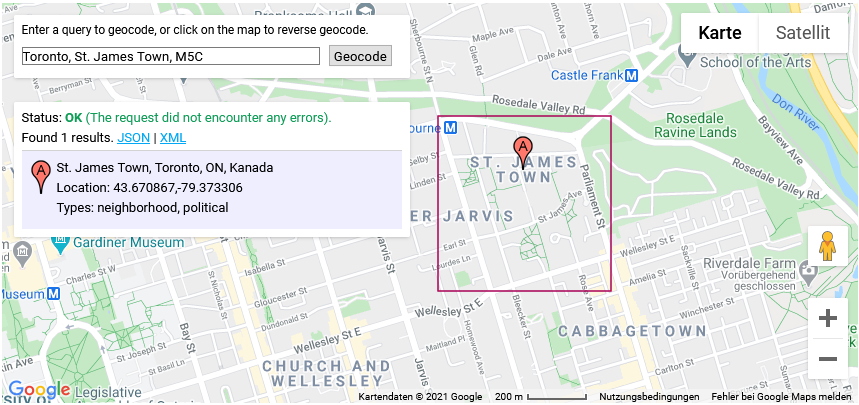

In [23]:
Image(filename='Coords Toronto.PNG') 

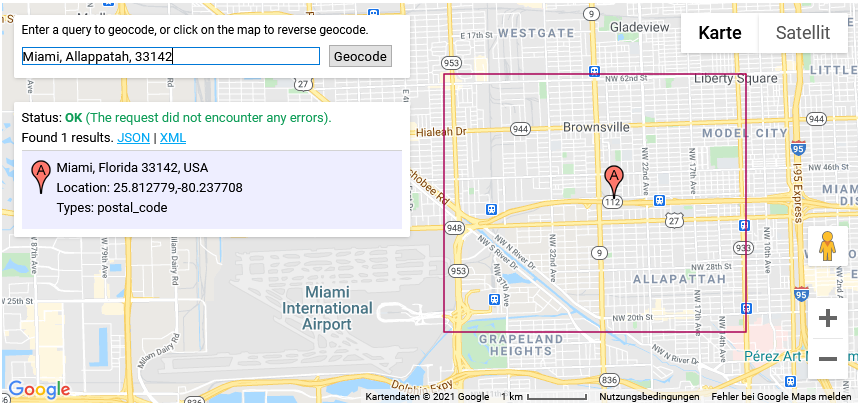

In [24]:
Image(filename='Miami.PNG') 

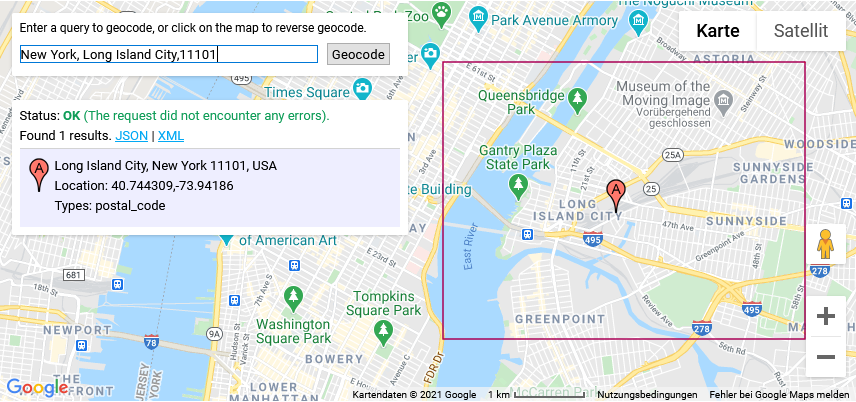

In [25]:
Image(filename='New York.PNG') 

### Append the found coordinates to the existing DataFrame and setting the "City" column as index:

In [26]:
coords = pd.DataFrame({"Latitude":[43.670867, 25.812779, 40.744309], "Longitude":[-79.373306, -80.237708, -73.94186]})
df_postalcodes = pd.concat([df_postalcodes, coords], axis=1)
df_postalcodes

City     Neighbourhood Postal Code   Latitude  Longitude
0   Toronto    St. James Town         M5C  43.670867 -79.373306
1     Miami        Allappatah       33142  25.812779 -80.237708
2  New York  Long Island City       11101  40.744309 -73.941860

In [27]:
df_postalcodes.index = df_postalcodes["City"]
df_postalcodes.drop(["City"], axis=1, inplace=True)
df_postalcodes

Neighbourhood Postal Code   Latitude  Longitude
City                                                        
Toronto     St. James Town         M5C  43.670867 -79.373306
Miami           Allappatah       33142  25.812779 -80.237708
New York  Long Island City       11101  40.744309 -73.941860

## Explore the neighbourhoods

In [28]:
CLIENT_ID = 'deleted ;)' # your Foursquare ID
CLIENT_SECRET = 'deleted ;)' # your Foursquare Secret
ACCESS_TOKEN = 'deleted ;)' # your FourSquare Access Token
VERSION = '20180605' # Foursquare API version


In [29]:
LIMIT = 150 # limit of number of venues returned by Foursquare API
radius = 800 # define radius
urls = []
for i in range(0, len(df_postalcodes),1):
    neighborhood_latitude = df_postalcodes.iloc[i, 2]
    neighborhood_longitude = df_postalcodes.iloc[i, 3]
    
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
        CLIENT_ID, 
        CLIENT_SECRET, 
        VERSION, 
        neighborhood_latitude, 
        neighborhood_longitude, 
        radius, 
        LIMIT)
    urls.append(url)

url_Toronto = urls[0]
url_Miami = urls[1]
url_NewYork = urls[2]
print("url_Toronto:")
print(url_Toronto)
print("\n")
print("url_Miami:")
print(url_Miami)
print("\n")
print("url_NewYork:")
print(url_NewYork)
print("\n")

url_Toronto:
https://api.foursquare.com/v2/venues/explore?&client_id=LIJ5G1V1QN13EIVSBVSV5FXGOD13EPXKO1LZEJSJNMYXXMSS&client_secret=AYFD2CKOYHH0GVPXYTZFNC35FFMGYAB0H5PLIT4NGV40LM4H&v=20180605&ll=43.670867,-79.373306&radius=800&limit=150


url_Miami:
https://api.foursquare.com/v2/venues/explore?&client_id=LIJ5G1V1QN13EIVSBVSV5FXGOD13EPXKO1LZEJSJNMYXXMSS&client_secret=AYFD2CKOYHH0GVPXYTZFNC35FFMGYAB0H5PLIT4NGV40LM4H&v=20180605&ll=25.812779,-80.237708&radius=800&limit=150


url_NewYork:
https://api.foursquare.com/v2/venues/explore?&client_id=LIJ5G1V1QN13EIVSBVSV5FXGOD13EPXKO1LZEJSJNMYXXMSS&client_secret=AYFD2CKOYHH0GVPXYTZFNC35FFMGYAB0H5PLIT4NGV40LM4H&v=20180605&ll=40.744309,-73.94186&radius=800&limit=150




Defining functions:

In [30]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [31]:
# create map of neighbourhoods using latitude and longitude values
def create_map(city, df_gyms_city):

        map_nearby_venues = folium.Map(location=[df_postalcodes.loc[city, "Latitude"], df_postalcodes.loc[city, "Longitude"]], zoom_start=16)

        # add markers to map
        for lat, lng, name, categories in zip(nearby_venues['lat'], nearby_venues['lng'], nearby_venues['name'], nearby_venues['categories']):
                label = '{}, {}'.format(name, categories)
                label = folium.Popup(label, parse_html=True)
                folium.CircleMarker(
                        [lat, lng],
                        radius=5,
                        popup=label,
                        color='blue',
                        fill=True,
                        fill_color='#3186cc',
                        fill_opacity=0.7,
                        parse_html=False).add_to(map_nearby_venues )  

        #add neighbourhood center marker:
        label = "centre of neighbourhood"
        label = folium.Popup(label, parse_html=True)
        folium.CircleMarker(
                [df_postalcodes.loc[city, "Latitude"], df_postalcodes.loc[city, "Longitude"]],
                radius=5,
                popup=label,
                color='red',
                fill=True,
                fill_color='red',
                fill_opacity=0.7,
                parse_html=False).add_to(map_nearby_venues )  

        #add gym marker:
        for lat, lng, name, categories in zip(df_gyms_city['lat'], df_gyms_city['lng'], df_gyms_city['name'], df_gyms_city['categories']):
                label = '{}, {}'.format(name, categories)
                label = folium.Popup(label, parse_html=True)
                folium.CircleMarker(
                        [lat, lng],
                        radius=5,
                        popup=label,
                        color='green',
                        fill=True,
                        fill_color='green',
                        fill_opacity=0.7,
                        parse_html=False).add_to(map_nearby_venues )  
        return map_nearby_venues

### 1) Explore Long Island City

In [32]:
#creating a Dataframe to store the amount of venues
df_number_venues = pd.DataFrame(columns = ["Venues"], index = ["Long Island City", "Allapattah", "St. James Town"])
df_number_venues

Venues
Long Island City    NaN
Allapattah          NaN
St. James Town      NaN

In [33]:
results = requests.get(url_NewYork).json()
#results

In [34]:
pd.set_option("max_rows", 200)

venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']

print("Potential features are:\n", nearby_venues.columns, "\n")
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

#store the venues in a seperate DataFrame
ny_venues = nearby_venues.copy()

#number of venues
print(f"found {len(nearby_venues)} nearby venues")
#store number of venues in DataFrame
df_number_venues.loc["Long Island City", "Venues"] = len(nearby_venues)

nearby_venues.head(50)



Potential features are:
 Index(['referralId', 'reasons.count', 'reasons.items', 'venue.id',
       'venue.name', 'venue.location.address', 'venue.location.crossStreet',
       'venue.location.lat', 'venue.location.lng',
       'venue.location.labeledLatLngs', 'venue.location.distance',
       'venue.location.postalCode', 'venue.location.cc', 'venue.location.city',
       'venue.location.state', 'venue.location.country',
       'venue.location.formattedAddress', 'venue.categories',
       'venue.delivery.id', 'venue.delivery.url',
       'venue.delivery.provider.name', 'venue.delivery.provider.icon.prefix',
       'venue.delivery.provider.icon.sizes',
       'venue.delivery.provider.icon.name', 'venue.photos.count',
       'venue.photos.groups', 'venue.venuePage.id',
       'venue.location.neighborhood'],
      dtype='object') 

found 100 nearby venues


name                categories  \
0                                        Levante               Pizza Place   
1                                Partners Coffee               Coffee Shop   
2                                   Book Culture                 Bookstore   
3                                    Dutch Kills              Cocktail Bar   
4                         Chipotle Mexican Grill        Mexican Restaurant   
5               MoMA PS1 Contemporary Art Center                Art Museum   
6                               Warm Up MoMA PS1               Music Venue   
7                                       Il Falco        Italian Restaurant   
8                                      Starbucks               Coffee Shop   
9                              The Burger Garage              Burger Joint   
10                          Pantry Market Eatery            Breakfast Spot   
11                             Food Cellar & Co.               Supermarket   
12                     MoMa PS1 Performance Dome             Indie Theater   
13                                Doughnut Plant                Donut Shop   
14                               SculptureCenter                Art Museum   
15                The Beast Next Door Cafe & Bar                       Bar   
16                                          Taim  Mediterranean Restaurant   
17                                     Indie LIC                Restaurant   
18  Hyatt Place Long Island City / New York City                     Hotel   
19                           James Turrell Space               Art Gallery   
20                       Linc LIC Fitness Center      Gym / Fitness Center   
21                                          Adda         Indian Restaurant   
22                            Court Square Diner                     Diner   
23                      John F Murray Playground                Playground   
24                             Etto Espresso Bar               Coffee Shop   
25                                          Chip              Dessert Shop   
26                           M. Wells Steakhouse                Steakhouse   
27                           Artbook at MoMA PS1                 Gift Shop   
28                                   Taste Crème                      Café   
29                                  Birch Coffee               Coffee Shop   
30                The Cliffs at Long Island City              Climbing Gym   
31                                Murray Dog Run                   Dog Run   
32                 Sugardaddy's Gentlemen's Club                 Nightclub   
33                                     Sweetleaf               Coffee Shop   
34              LaGuardia Pool & Aquatics Center                  Gym Pool   
35                           Hunters Point Plaza                     Plaza   
36                       YiFang Taiwan Fruit Tea           Bubble Tea Shop   
37                                    Communitea               Coffee Shop   
38                         CityView Racquet Club              Tennis Court   
39                                      Möge Tee           Bubble Tea Shop   
40                             Court Square Park                      Park   
41                                        Waheyo        Mexican Restaurant   
42         Aloft Long Island City-Manhattan View                     Hotel   
43                                    Manducatis        Italian Restaurant   
44                 CrossFit LIC - Noskov Fitness                       Gym   
45                                    Bierocracy               Beer Garden   
46                                          Jora       Peruvian Restaurant   
47                                      Mu Ramen          Ramen Restaurant   
48                              Clever Blend Lic               Coffee Shop   
49                                  Camp Bow Wow               Pet Service   

          lat        lng  
0   40.747518 -73.941590  
1   40.7475

In [35]:
groupby_counts_NY = nearby_venues.groupby("categories").count().sort_values("name", ascending=False)
groupby_counts_NY.head(150)

name  lat  lng
categories                              
Coffee Shop                 12   12   12
Café                         6    6    6
Hotel                        4    4    4
Bubble Tea Shop              4    4    4
Deli / Bodega                3    3    3
Gym / Fitness Center         3    3    3
Donut Shop                   3    3    3
Pizza Place                  2    2    2
Italian Restaurant           2    2    2
Indie Theater                2    2    2
Indian Restaurant            2    2    2
Art Museum                   2    2    2
Gym                          2    2    2
Mediterranean Restaurant     2    2    2
Art Gallery                  2    2    2
Mexican Restaurant           2    2    2
Restaurant                   2    2    2
Bank                         2    2    2
Bar                          2    2    2
Sporting Goods Shop          1    1    1
Mobile Phone Shop            1    1    1
Tennis Court                 1    1    1
Supermarket                  1    1    1
Steakhouse                   1    1    1
Music Venue                  1    1    1
Nightclub                    1    1    1
Playground                   1    1    1
Plaza                        1    1    1
North Indian Restaurant      1    1    1
Park                         1    1    1
Performing Arts Venue        1    1    1
Skating Rink                 1    1    1
Peruvian Restaurant          1    1    1
Pet Service                  1    1    1
Pharmacy                     1    1    1
Ramen Restaurant             1    1    1
Soccer Field                 1    1    1
Hostel                       1    1    1
Market                       1    1    1
Juice Bar                    1    1    1
Arts & Entertainment         1    1    1
Athletics & Sports           1    1    1
Bakery                       1    1    1
Beer Garden                  1    1    1
Bookstore                    1    1    1
Breakfast Spot               1    1    1
Burger Joint                 1    1    1
Caribbean Restaurant         1    1    1
Cheese Shop                  1    1    1
Climbing Gym                 1    1    1
Cocktail Bar                 1    1    1
Dessert Shop                 1    1    1
Diner                        1    1    1
Dog Run                      1    1    1
Dumpling Restaurant          1    1    1
General Entertainment        1    1    1
Gift Shop                    1    1    1
Gym Pool                     1    1    1
Health Food Store            1    1    1
Wine Shop                    1    1    1

In [36]:
#finding the gym locations and store them in the dict: dict_gyms
df_gyms_NewYork = nearby_venues[nearby_venues['categories'].str.contains("Gym|gym")]
gyms_NewYork = len(df_gyms_NewYork)
dict_gyms = {"City": ["New York"], "Neighbourhood": ["Long Island City"], "Gyms": [gyms_NewYork]}

In [37]:
create_map("New York", df_gyms_NewYork)


Since folium maps won't displayed at GitHub; here is the picture:<br>
Red: Center of neighbourhood<br>
Blue: Different venues<br>
Green: Gym venues<br>

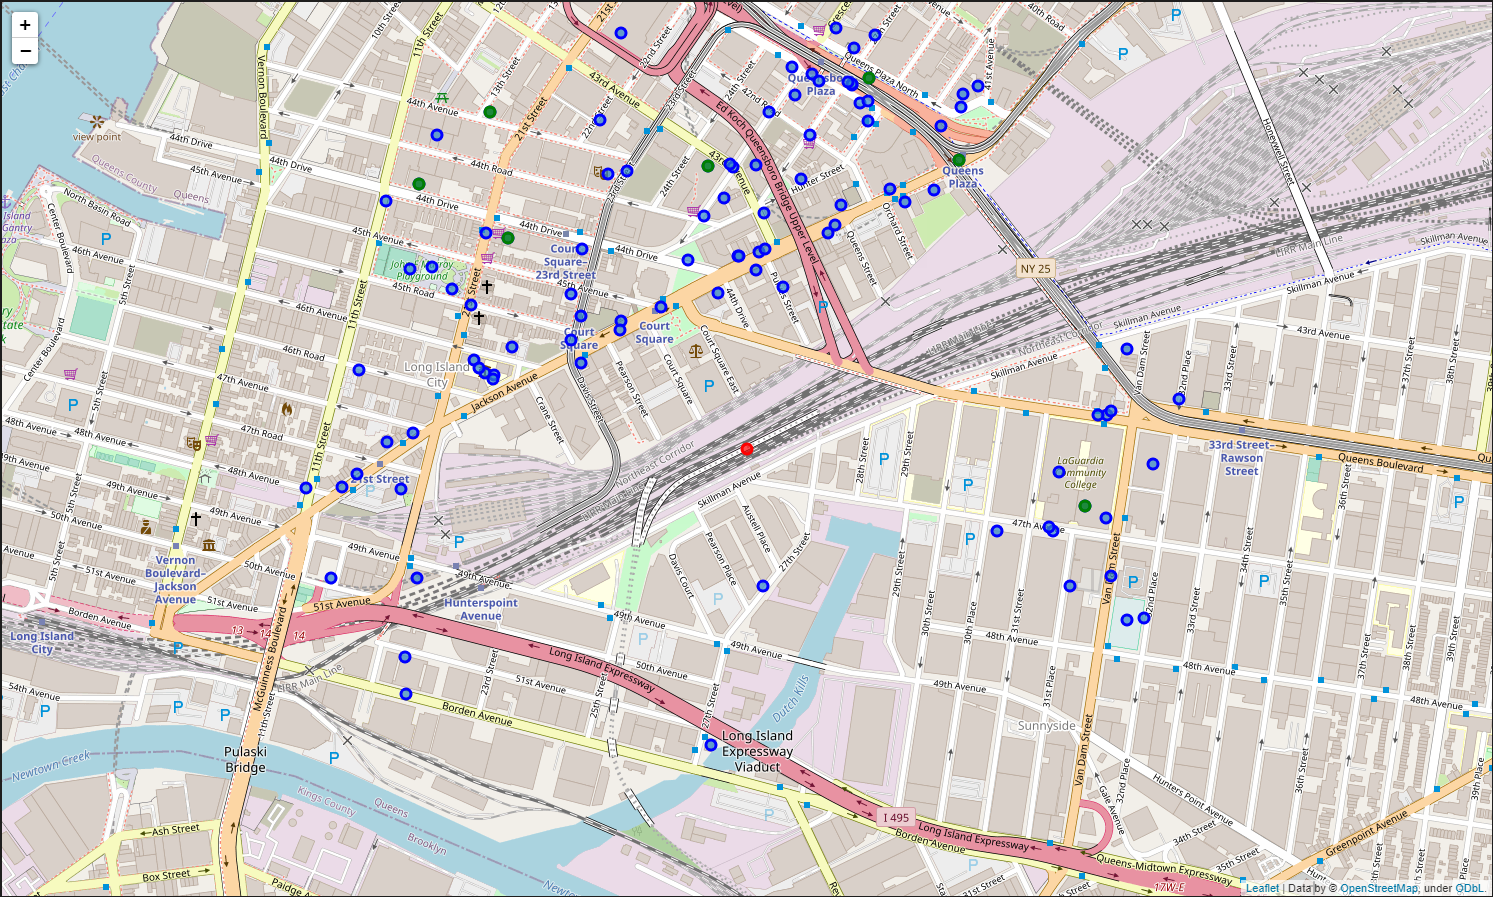

In [38]:
#since folium maps won't displayed at GitHub; here is the picture:
Image(filename='folium_ny.PNG') 

### 2) Explore Allapattah

In [39]:
results = requests.get(url_Miami).json()
#results

In [40]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

#store the venues in a seperate DataFrame
miami_venues = nearby_venues.copy()

#number of venues
print(f"found {len(nearby_venues)} nearby venues")
#store number of venues in DataFrame
df_number_venues.loc["Allapattah", "Venues"] = len(nearby_venues)

nearby_venues.head(50)

found 20 nearby venues


name                categories  \
0                                      Wendy’s      Fast Food Restaurant   
1                                          KFC       Fried Chicken Joint   
2           U-Haul Moving & Storage at 36th St          Storage Facility   
3                                       Subway            Sandwich Place   
4                                   McDonald's      Fast Food Restaurant   
5                                        Shell               Gas Station   
6                                    Taco Bell      Fast Food Restaurant   
7                    El Presidente Supermarket         Food & Drink Shop   
8                                    Studio 60                 Nightclub   
9                            L' Boulevard Cafe                 Nightclub   
10                                 Burger King      Fast Food Restaurant   
11                        Thermo King of Miami              Home Service   
12   Florida Motorcycle Training Of North Dade  Bike Rental / Bike Share   
13                   Lejune and 112 Expressway              Intersection   
14                             Beauty Exchange            Cosmetics Shop   
15                       Tropicana Flea Market               Flea Market   
16                           Joe's Meat Market             Grocery Store   
17                                     Mazie's                      Food   
18                                       Tacos                Food Truck   
19  MDT Metrorail - Earlington Heights Station        Light Rail Station   

          lat        lng  
0   25.811238 -80.239864  
1   25.811704 -80.240005  
2   25.808879 -80.237750  
3   25.813109 -80.240756  
4   25.809014 -80.232281  
5   25.808809 -80.239825  
6   25.811701 -80.239949  
7   25.809744 -80.231959  
8   25.809007 -80.234309  
9   25.809720 -80.238601  
10  25.809458 -80.239909  
11  25.815226 -80.239621  
12  25.815828 -80.237264  
13  25.812624 -80.241375  
14  25.816735 -80.236082  
15  25.809784 -80.243880  
16  25.816633 -80.232063  
17  25.817003 -80.232079  
18  25.808486 -80.231861  
19  25.812449 -80.229974

In [41]:
nearby_venues.groupby("categories").count()

name  lat  lng
categories                              
Bike Rental / Bike Share     1    1    1
Cosmetics Shop               1    1    1
Fast Food Restaurant         4    4    4
Flea Market                  1    1    1
Food                         1    1    1
Food & Drink Shop            1    1    1
Food Truck                   1    1    1
Fried Chicken Joint          1    1    1
Gas Station                  1    1    1
Grocery Store                1    1    1
Home Service                 1    1    1
Intersection                 1    1    1
Light Rail Station           1    1    1
Nightclub                    2    2    2
Sandwich Place               1    1    1
Storage Facility             1    1    1

In [42]:
df_gyms_Miami = nearby_venues[nearby_venues['categories'].str.contains("Gym|gym")]
gyms_Miami = len(df_gyms_Miami)
#dict_gyms.update({"City": "Miami", "Neighbourhood": "Allapattah", "Gyms": gyms_Miami})
dict_gyms["City"].append("Miami")
dict_gyms["Neighbourhood"].append("Allapattah")
dict_gyms["Gyms"].append(gyms_Miami)

In [43]:
create_map("Miami", df_gyms_Miami)

Since folium maps won't displayed at GitHub; here is the picture:<br>
Red: Center of neighbourhood<br>
Blue: Different venues<br>
Green: Gym venues<br>

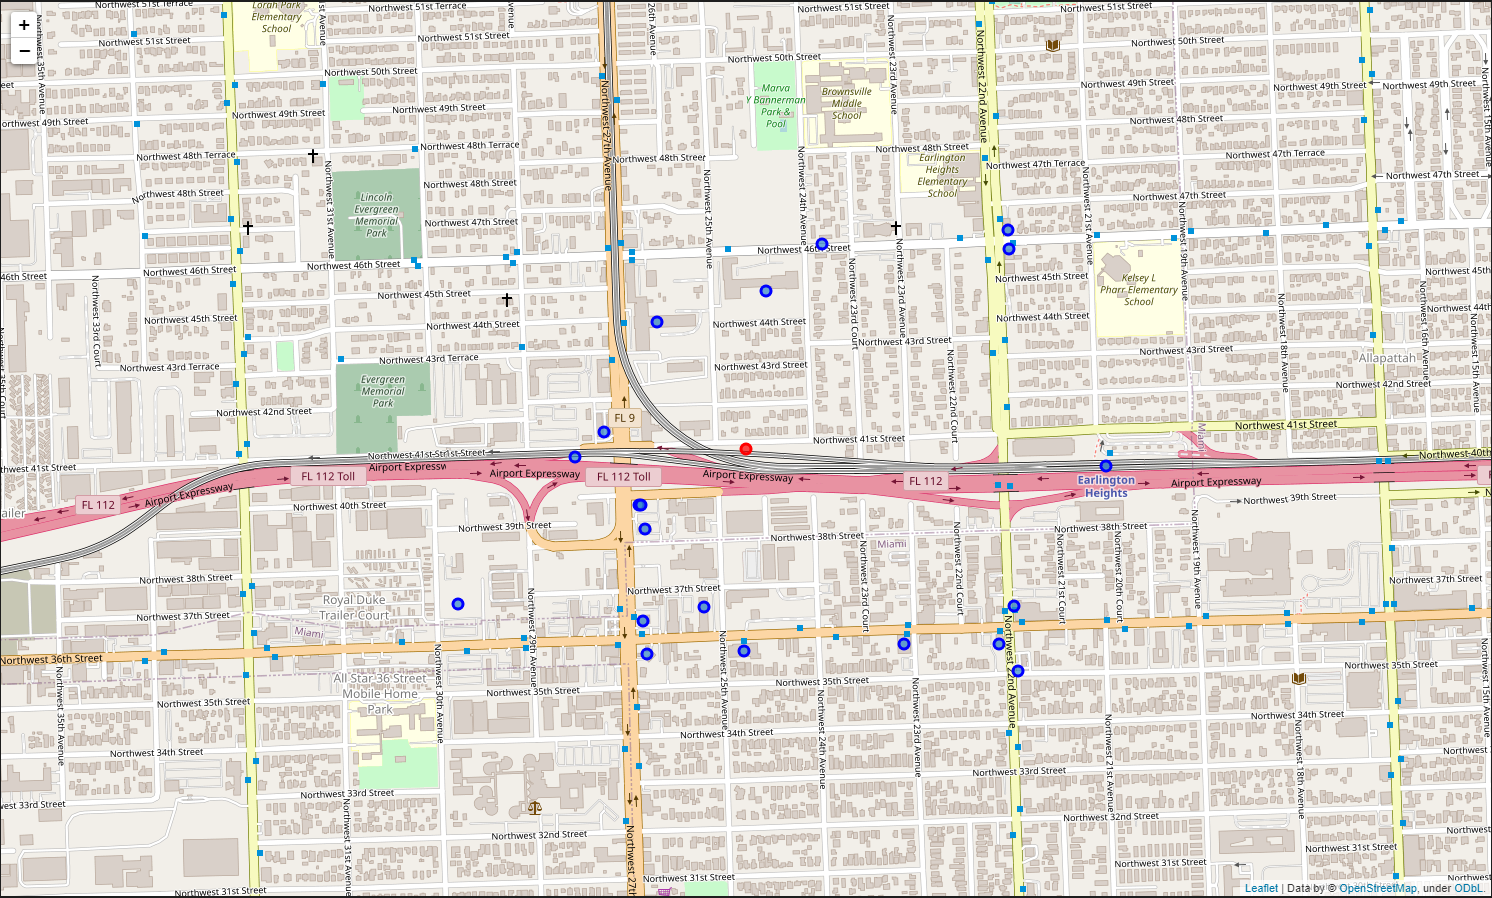

In [44]:
Image(filename='folium_miami.PNG') 

### 3) Explore St. James Town

In [45]:
results = requests.get(url_Toronto).json()
#results

In [46]:
pd.set_option("max_rows", 100)

venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

#store the venues in a seperate DataFrame
toronto_venues = nearby_venues.copy()

#number of venues
print(f"found {len(nearby_venues)} nearby venues")
#store number of venues in DataFrame
df_number_venues.loc["St. James Town", "Venues"] = len(nearby_venues)

nearby_venues.head(50)

found 80 nearby venues


name             categories        lat  \
0                              Maison Selby                 Bistro  43.671232   
1                                  Mr. Jerk   Caribbean Restaurant  43.667328   
2                               Cranberries                  Diner  43.667843   
3                      Rooster Coffee House            Coffee Shop  43.669654   
4                                Murgatroid             Restaurant  43.667381   
5                  The Keg Steakhouse + Bar             Steakhouse  43.666756   
6                                  F'Amelia     Italian Restaurant  43.667536   
7                    Absolute Bakery & Café                 Bakery  43.667469   
8                          Cabbagetown Brew                   Café  43.666923   
9                  Merryberry Cafe + Bistro                   Café  43.666630   
10                                   Tinuno    Filipino Restaurant  43.671281   
11                   Butter Chicken Factory      Indian Restaurant  43.667072   
12                           Kingyo Toronto    Japanese Restaurant  43.665895   
13                              Pie Squared               Pie Shop  43.672143   
14                        Red Rocket Coffee            Coffee Shop  43.666528   
15          Sunny Green Vegetable and Fruit                 Market  43.667555   
16                        Out On The Street            Men's Store  43.668293   
17                        Barbara Hall Park                   Park  43.666879   
18                                 Fabarnak             Restaurant  43.666377   
19                                    Smith         Breakfast Spot  43.666927   
20                 Fair Trade Jewellery Co.          Jewelry Store  43.665348   
21                   Church Street Espresso                   Café  43.668292   
22                                Starbucks            Coffee Shop  43.671082   
23               St. Jamestown Delicatessen                Butcher  43.665811   
24                      Piedmont Coffee Bar            Coffee Shop  43.668286   
25                                  Gabby's                    Bar  43.669916   
26                                  FreshCo          Grocery Store  43.669064   
27                          The Blake House    American Restaurant  43.664468   
28  Toronto Public Library (St. James Town)                Library  43.668790   
29                           Isabella Hotel                  Hotel  43.670098   
30                    Toronto Dance Theatre  General Entertainment  43.666232   
31                  Phoenix Concert Theatre              Rock Club  43.664674   
32                            Booster Juice              Juice Bar  43.671566   
33                  Cawthra Square Dog Park                Dog Run  43.666583   
34                            The Pear Tree             Restaurant  43.664904   
35                                No Frills          Grocery Store  43.671616   
36                       Manulife Financial                 Office  43.672070   
37                                    Flock            Salad Place  43.670604   
38                              Tim Hortons            Coffee Shop  43.669855   
39                                  O. Noir             Restaurant  43.669145   
40                           Jetfuel Coffee            Coffee Shop  43.665295   
41                          Winchester Park             Playground  43.666231   
42                       Shoppers Drug Mart               Pharmacy  43.670177   
43                          TD Canada Trust                   Bank  43.672484   
44                 Nijo Japanese Restaurant    Japanese Restaurant  43.671849   
45                       Aroma Espresso Bar            Coffee Shop  43.672154   
46                              Tim Hortons            Coffee Shop  43.667820   
47                            Handy Variety      Food & Drink Shop  43.669828   
48                               Sushi Shop             Restaurant  43

In [47]:
nearby_venues.groupby("categories").count().sort_values("name", ascending=False)

name  lat  lng
categories                              
Coffee Shop                 16   16   16
Restaurant                   5    5    5
Café                         4    4    4
Pizza Place                  3    3    3
Sandwich Place               3    3    3
Grocery Store                3    3    3
Japanese Restaurant          2    2    2
Breakfast Spot               2    2    2
Pub                          2    2    2
Hotel                        2    2    2
Gym / Fitness Center         2    2    2
Office                       1    1    1
Liquor Store                 1    1    1
Market                       1    1    1
Men's Store                  1    1    1
Metro Station                1    1    1
American Restaurant          1    1    1
Park                         1    1    1
Pharmacy                     1    1    1
Pie Shop                     1    1    1
Juice Bar                    1    1    1
Playground                   1    1    1
Rental Car Location          1    1    1
Rock Club                    1    1    1
Salad Place                  1    1    1
Steakhouse                   1    1    1
Library                      1    1    1
Irish Pub                    1    1    1
Jewelry Store                1    1    1
Diner                        1    1    1
Bank                         1    1    1
Bar                          1    1    1
Beer Store                   1    1    1
Bike Rental / Bike Share     1    1    1
Bistro                       1    1    1
Butcher                      1    1    1
Caribbean Restaurant         1    1    1
Dog Run                      1    1    1
Italian Restaurant           1    1    1
Fast Food Restaurant         1    1    1
Filipino Restaurant          1    1    1
Food & Drink Shop            1    1    1
Gas Station                  1    1    1
General Entertainment        1    1    1
Indian Restaurant            1    1    1
Bakery                       1    1    1
Sushi Restaurant             1    1    1

In [48]:
df_gyms_Toronto = nearby_venues[nearby_venues['categories'].str.contains("Gym|gym")]
gyms_Toronto = len(df_gyms_Toronto)
#dict_gyms.update({"City": "Toronto", "Neighbourhood": "St. James Town", "Gyms": gyms_Toronto})
dict_gyms["City"].append("Toronto")
dict_gyms["Neighbourhood"].append("St. James Town")
dict_gyms["Gyms"].append(gyms_Toronto)

In [49]:
create_map("Toronto", df_gyms_Toronto)

Since folium maps won't displayed at GitHub; here is the picture:<br>
Red: Center of neighbourhood<br>
Blue: Different venues<br>
Green: Gym venues<br>

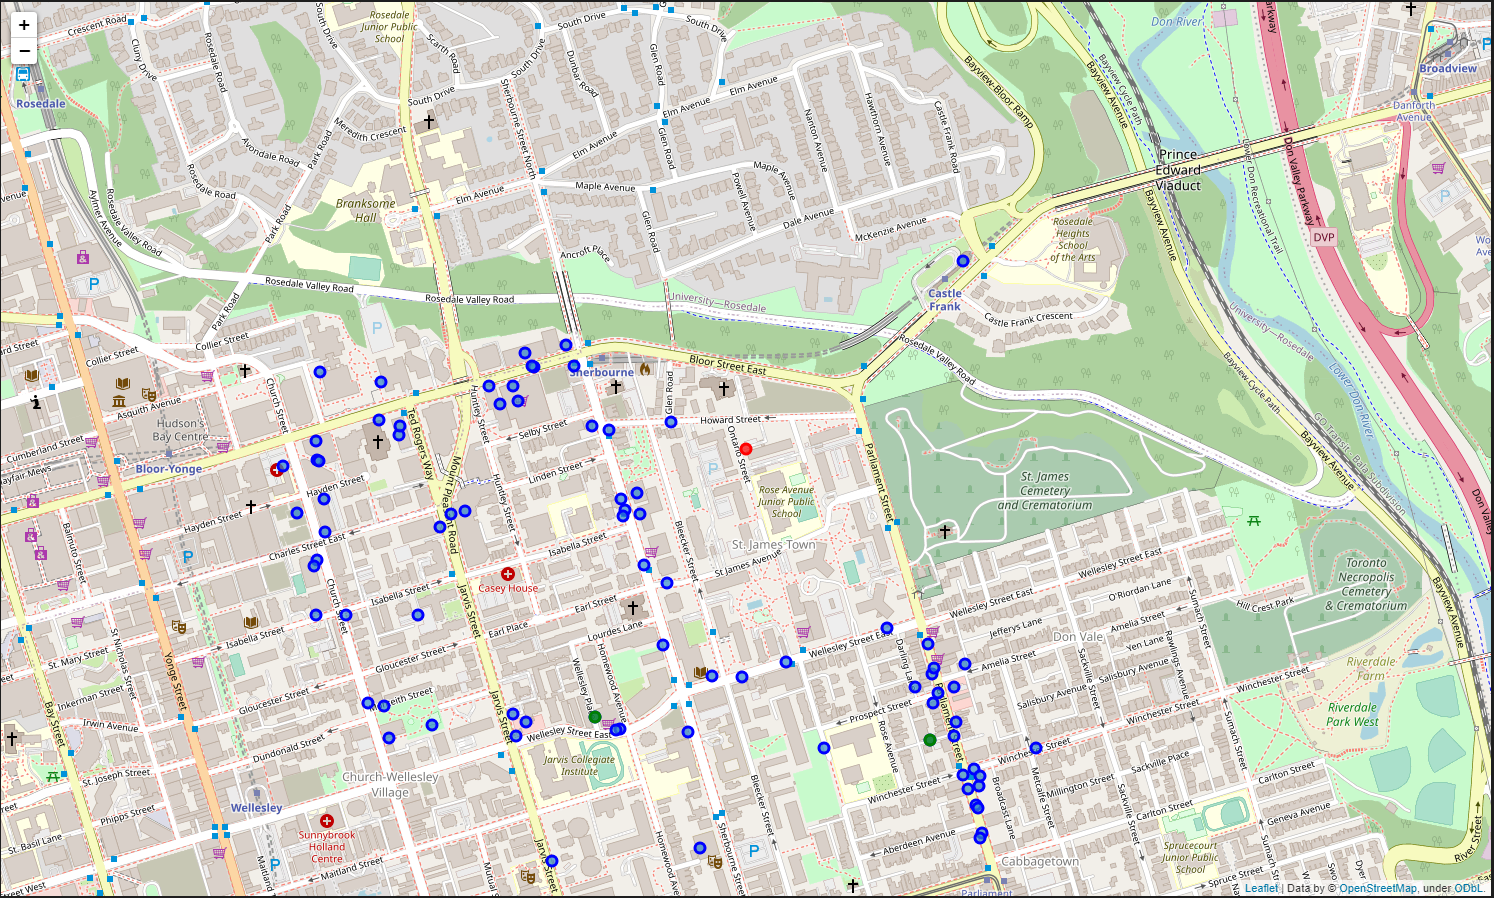

In [50]:
Image(filename='folium_Toronto.PNG') 

# Comparing the amount of gyms to choose the best location:

In [51]:
df_overall = pd.DataFrame(dict_gyms)
df_overall.index = (df_overall["Neighbourhood"])
df_overall.drop("Neighbourhood", axis=1, inplace=True)
df_overall

City  Gyms
Neighbourhood                   
Long Island City  New York     7
Allapattah           Miami     0
St. James Town     Toronto     2

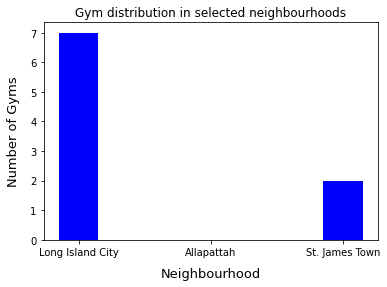

In [52]:
X = df_overall.index
Y = df_overall["Gyms"]

plt.bar(X,Y, width=0.3, bottom=0, align="center", color = "blue")
plt.title("Gym distribution in selected neighbourhoods")
plt.xlabel("Neighbourhood", labelpad=10, fontsize=13)
plt.ylabel("Number of Gyms", labelpad=10, fontsize=13)
plt.savefig("number_gyms.png", bbox_inches = "tight")
plt.show()

## As one can see from figure "Gym distribution in selected neighbourhoods", there are seven gyms in the Long Island City area, zero in Allapattah and two in St. James Town.

## <p align="justify">In order to avoid unnecessary competition, Allapattah would be the best choice at first sight. However, we have to take the customer potential into account. This can be expressed by the overall amount of venues for each neighbourhood, as well as by the neighbourhood population.</p>

## Comparing the amount of venues for every neighbourhood:

In [53]:
df_overall["Venues"] = df_number_venues["Venues"]
df_overall

City  Gyms Venues
Neighbourhood                          
Long Island City  New York     7    100
Allapattah           Miami     0     20
St. James Town     Toronto     2     80

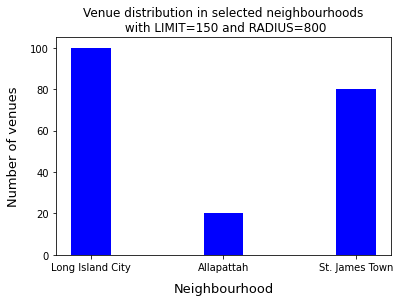

In [54]:
X = df_overall.index
Y = df_overall["Venues"]

plt.bar(X,Y, width=0.3, bottom=0, align="center", color = "blue")

plt.title("Venue distribution in selected neighbourhoods\n with LIMIT=150 and RADIUS=800")
plt.xlabel("Neighbourhood", labelpad=10, fontsize=13)
plt.ylabel("Number of venues", labelpad=10, fontsize=13)
plt.savefig("number_venues.png", bbox_inches = "tight")
plt.show()


## Taking the population of the neighbourhood into account:

Population data for Allapattah und St. James Town have already been scraped from the web.<br>
The population data for Long Island City can be found under the following link:

Long Island City: <br>
https://www.point2homes.com/US/Neighborhood/NY/Queens/Long-Island-City-Demographics.html


In [55]:
population_LIC = 48188
population_ALL = int(df_miami.loc["Population","Value"])
population_SJT = int(str(df_new_york2.Population.max()).replace(".",""))
population_list = [population_LIC, population_ALL, population_SJT]

In [56]:
df_overall["Population"]=population_list
df_overall

City  Gyms Venues  Population
Neighbourhood                                      
Long Island City  New York     7    100       48188
Allapattah           Miami     0     20        4904
St. James Town     Toronto     2     80       25484

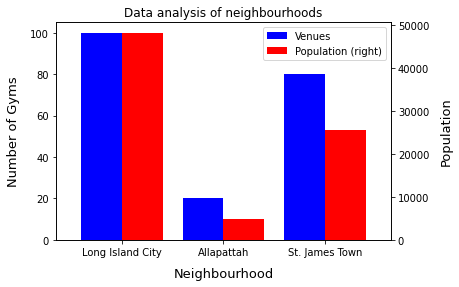

In [57]:
ax = df_overall[["Venues", "Population"]].plot( kind= 'bar' , width= 0.8, secondary_y= 'Population' , rot= 0 , color=["blue", "red", "green"], title="Data analysis of neighbourhoods")
ax.set_xlabel("Neighbourhood", labelpad=10, fontsize=13)
ax.set_ylabel("Number of Gyms", labelpad=10, fontsize=13)
ax.right_ax.set_ylabel("Population", labelpad=10, fontsize=13)
plt.savefig("Data_analysis.png", bbox_inches = "tight")
plt.show()

# As seen in figure "Data analysis of neighbourhoods", St. James Town has a higher customer potential since the overall amount of venues and the population are both higher. 

# We can cluster the venues in St. James Town to get places of high interest by using k-means. Afterwards we can check, if there are any gyms in the highlighted areas 

In [58]:
#creating the feature set (coordinates) for training the model
nearby_venues = toronto_venues
feature_matrix = np.column_stack((nearby_venues["lat"], nearby_venues["lng"]))
print(len(feature_matrix))
feature_matrix[0:10]

80


array([[ 43.67123192, -79.37661767],
       [ 43.66732847, -79.37338944],
       [ 43.66784277, -79.36940688],
       [ 43.66965379, -79.37987057],
       [ 43.66738149, -79.36931129],
       [ 43.66675618, -79.37830242],
       [ 43.66753591, -79.36861331],
       [ 43.66746946, -79.36927655],
       [ 43.6669228 , -79.3692893 ],
       [ 43.6666302 , -79.36879184]])

## Checking for the best k value by comparing the sum of squares of the distances of points from their respective cluster centroids:

In [60]:
#searching for the best k
X_error = []
Y_error = []
for i in range(1, 11,1):
    k_means = KMeans(init="k-means++", n_clusters=i, n_init=50)
    k_means.fit(feature_matrix)
    error = k_means.inertia_
    X_error.append(i)
    Y_error.append(error)

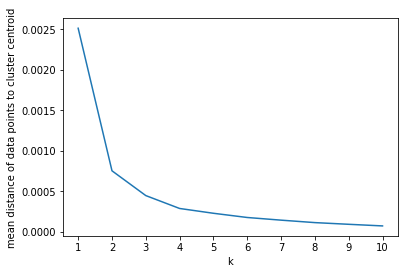

In [61]:
plt.plot(X_error,Y_error)
plt.ylabel("mean distance of data points to cluster centroid")
plt.xlabel("k")
plt.xticks(X_error)
plt.savefig("k_means_error", bbox_inches = "tight")
plt.show()

### The so called elbow point is located at k = 4, so we will use the model with 4 clusters:

In [62]:
#training the model and extracting the cluster label and the center coordinates
k_means = KMeans(init="k-means++", n_clusters=4, n_init=50)
k_means.fit(feature_matrix)
k_means_labels = k_means.labels_
k_means_cluster_centers = k_means.cluster_centers_

In [63]:
k_means_cluster_centers

array([[ 43.66672514, -79.36890114],
       [ 43.67127762, -79.37697952],
       [ 43.66955736, -79.38153181],
       [ 43.66687019, -79.37566237]])

In [64]:
k_means_out = np.column_stack((nearby_venues["name"],nearby_venues["categories"], feature_matrix, k_means_labels))
k_means_out[0:10]

array([['Maison Selby', 'Bistro', 43.6712319213305, -79.3766176700592, 1],
       ['Mr. Jerk', 'Caribbean Restaurant', 43.66732847256732,
        -79.37338943621165, 3],
       ['Cranberries', 'Diner', 43.6678427705951, -79.36940687874281, 0],
       ['Rooster Coffee House', 'Coffee Shop', 43.66965378571954,
        -79.379870566686, 2],
       ['Murgatroid', 'Restaurant', 43.66738149016019,
        -79.36931129229457, 0],
       ['The Keg Steakhouse + Bar', 'Steakhouse', 43.66675618397813,
        -79.37830241801962, 3],
       ["F'Amelia", 'Italian Restaurant', 43.66753590663226,
        -79.36861331485827, 0],
       ['Absolute Bakery & Café', 'Bakery', 43.667469462461995,
        -79.36927654747196, 0],
       ['Cabbagetown Brew', 'Café', 43.66692279890784,
        -79.36928929560437, 0],
       ['Merryberry Cafe + Bistro', 'Café', 43.66663020301851,
        -79.36879184199822, 0]], dtype=object)

In [65]:
k_means_cluster_out = np.column_stack((k_means_cluster_centers, np.linspace(0, len(k_means_cluster_centers)-1, len(k_means_cluster_centers))))
k_means_cluster_out

array([[ 43.66672514, -79.36890114,   0.        ],
       [ 43.67127762, -79.37697952,   1.        ],
       [ 43.66955736, -79.38153181,   2.        ],
       [ 43.66687019, -79.37566237,   3.        ]])

In [66]:
#showing the clusters by using different color and sizes:
#The colors are defined with the colormap "coolwarm"

def create_cluster_map(k_means_out, k_means_cluster_out, df_gyms_city):
        
        map_nearby_venues = folium.Map(location=[df_postalcodes.loc["Toronto", "Latitude"], df_postalcodes.loc["Toronto", "Longitude"]], zoom_start=16)

        #I will use a colormap to divide the clusters by color automatically
        cmap = cm.get_cmap("rainbow", 256)
        
        #add clustered venues by using a colorcode 
        for i in range(0, len(k_means_out),1):
            name = k_means_out[i,0]
            categorie = k_means_out[i,1]
            lat = k_means_out[i,2]
            lng = k_means_out[i,3]
            cluster_typ = k_means_out[i,4]
            label = '{}, {}'.format(name, categorie)
            label = folium.Popup(label, parse_html=True)
            color = cmap(float(abs(cluster_typ-0)/((len(k_means_cluster_out)-1)-0)))
            folium.CircleMarker(
                [lat, lng],
                radius = 6,
                popup=label,
                color = "black",
                fill=True,
                fill_color=libc.to_hex(color, keep_alpha=False),
                fill_opacity=1,
                parse_html=False).add_to(map_nearby_venues)

        #add the cluster centers by using the same colorcode as before
        for i in range(0, len(k_means_cluster_out),1):
            lat = k_means_cluster_out[i,0]
            lng = k_means_cluster_out[i,1]
            cluster_typ = k_means_cluster_out[i,2]
            label = f"Cluser center {int(cluster_typ) }"
            color = cmap(float(abs(cluster_typ-0)/((len(k_means_cluster_out)-1)-0)))
            folium.CircleMarker(
                [lat, lng],
                radius = 12,
                popup=label,
                color = "black",
                fill=True,
                fill_color=libc.to_hex(color, keep_alpha=False),
                fill_opacity=1,
                parse_html=False).add_to(map_nearby_venues)

        #add the gym venues in green
        for lat, lng, name, categories in zip(df_gyms_city['lat'], df_gyms_city['lng'], df_gyms_city['name'], df_gyms_city['categories']):
            label = '{}, {}'.format(name, categories)
            label = folium.Popup(label, parse_html=True)
            folium.CircleMarker(
                    [lat, lng],
                    radius=6,
                    popup=label,
                    color='black',
                    fill=True,
                    fill_color='green',
                    fill_opacity=0.7,
                    parse_html=False).add_to(map_nearby_venues )  

        return map_nearby_venues

## Cluster Map: Different colors are marking the venue clusters

Green color displays a Gym venue.

The big circles show the center of the cluster.

In [67]:
create_cluster_map(k_means_out, k_means_cluster_out, df_gyms_Toronto)

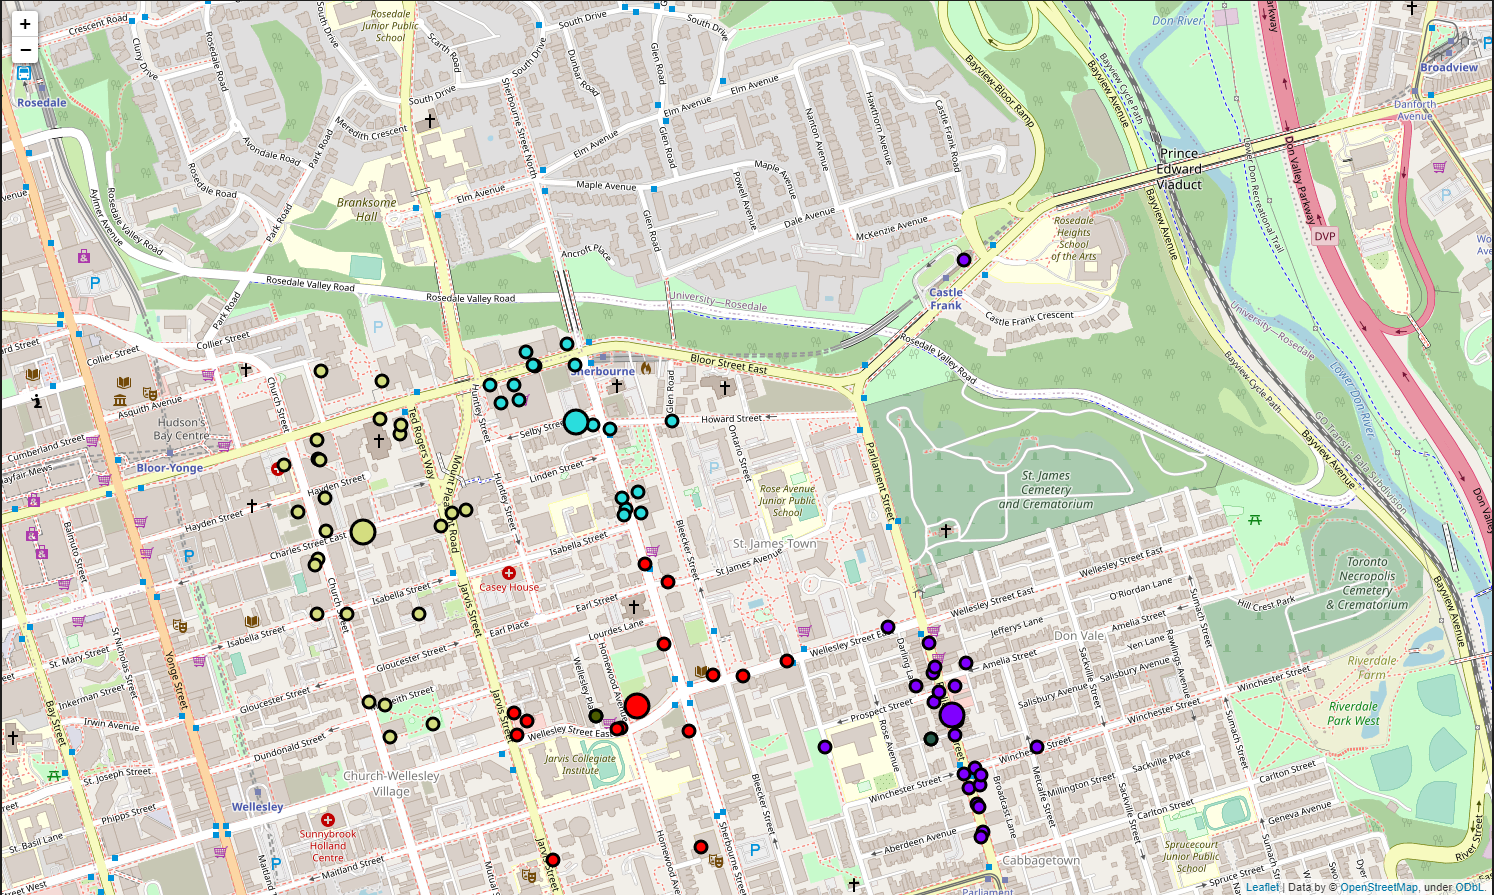

In [68]:
Image(filename='cluster.PNG') 

# Clustering shows the different typs of area with a higher amount of venues. 

# The Gym should be build in St. James Town: Either in the area which is displayed by the yellow cluster segment or by the blue cluster segment, since there are no gyms yet.

# THANKS FOR WATCHING :)